In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from gridworld_env import GridworldEnv

In [2]:
env = GridworldEnv('1') # Number of plan 

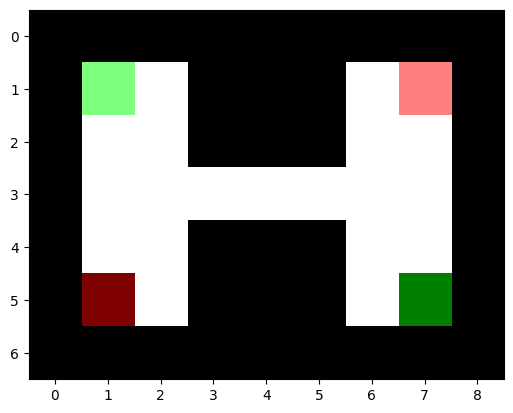

In [3]:
env.render()

In [4]:
env.observation_space

Box(0, 6, (7, 9), int64)

In [5]:
print(env.reset())
#print(env.action_space.sample())
env.step([env.action_space[0].sample(),env.action_space[1].sample()])
#env.step(env.action_space.sample())

[1, 1, 1, 7, 0, 0, 0, 0]


([1, 1, 1, 7, 1, 0, 4, 0], [-0.1, -0.1], [False, False])

In [7]:
env.verbose = True

In [11]:
env.current_grid_map.shape

(7, 9)

In [13]:
env.observation_space

Box(0, 6, (7, 9), int64)

In [14]:
env.action_space

{0: Discrete(5), 1: Discrete(5)}

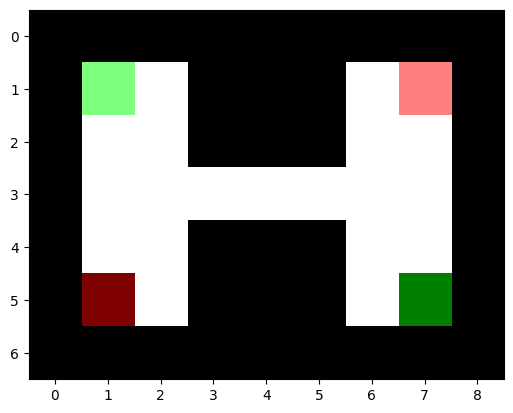

State 				 - Reward
[1, 2, 1, 6, 4, 0, 3, 0] 			 [-0.1, -0.1]


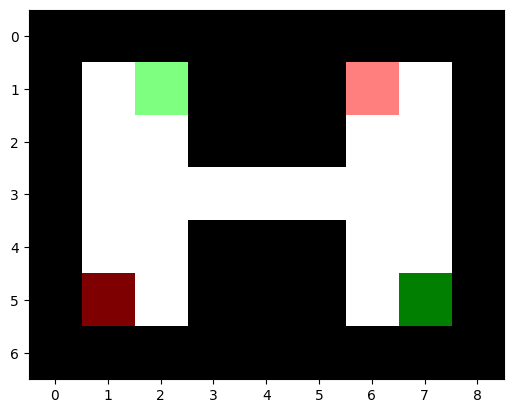

[5, 7, 1, 6, 3, 1, 1, 0] 			 [0.0, -0.1]


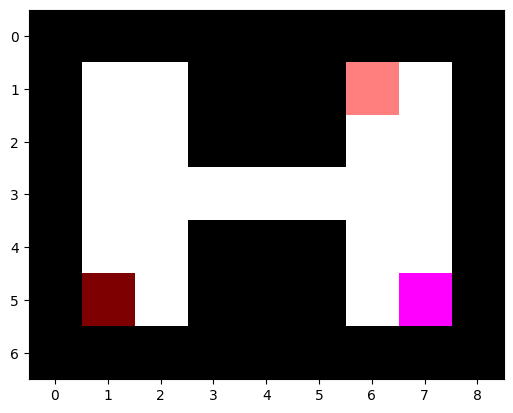

Total episode reward:  0.0


In [15]:
# Try random policy, seems to work
env.reset()
env.render()
print('State \t\t\t\t - Reward')

for i in range(1000):
    move0,move1 = env.action_space[0].sample(),env.action_space[1].sample()
    #move0=1
    #move1=1
    obs , rewards, move_completed =  env.step([move0,move1]) 

    if i%500==0: 
        print(obs,'\t\t\t',rewards)
        env.render()
    
print('Total episode reward: ', env.episode_total_reward)

## Q-learning Example

In [16]:
# Q learning params
ALPHA = 0.1 # learning rate
GAMMA = 0.95 # reward discount
LEARNING_COUNT = 1000
TEST_COUNT = 100

TURN_LIMIT = 1000
IS_MONITOR = True
from algorithms.Q_Learning import Q_Learning_Agents


env = GridworldEnv('1')
env.reset()
agents = Q_Learning_Agents(env,LEARNING_COUNT,TURN_LIMIT,ALPHA,GAMMA)

print("###### LEARNING #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(LEARNING_COUNT):
    epsilon = agents.update_epsilon(i)
    total_reward,reward_1,reward_2=agents.learn(epsilon)
    reward_total_1 += reward_1
    reward_total_2 += reward_2
print("episodes      : {}".format(LEARNING_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / LEARNING_COUNT))
#print("agent 1 Q Value       :{}".format(agent.q_val))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / LEARNING_COUNT))
#print("agent 2 Q Value       :{}".format(agent2.q_val))

"""
print("###### TEST #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(TEST_COUNT):
    reward_total_1 += agent1.test()
    reward_total_2 += agent2.test()
print("episodes      : {}".format(TEST_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))
"""


###### LEARNING #####
episodes      : 1000
agent 1 total reward  : 67320.90000000002
agent 1 average reward: 67.32
agent 2 total reward  : 70095.30000000006
agent 2 average reward: 70.10


'\nprint("###### TEST #####")\nreward_total_1 = 0.0\nreward_total_2 = 0.0\nfor i in range(TEST_COUNT):\n    reward_total_1 += agent1.test()\n    reward_total_2 += agent2.test()\nprint("episodes      : {}".format(TEST_COUNT))\nprint("agent 1 total reward  : {}".format(reward_total_1))\nprint("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))\nprint("agent 2 total reward  : {}".format(reward_total_2))\nprint("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))\n'

In [17]:

Q_a1 = agents.q_val_1
Q_a1_fixed_p2=Q_a1[:,:,1,7,:,:,:]
#Q_a1_fixed_p2=Q_a1
Q_a1_mean=np.mean(Q_a1_fixed_p2,axis=tuple(i for i in range(Q_a1_fixed_p2.ndim) if i != 0 and i!=1 and i!=4))

#print(Q_a1_mean[:,:,0])
policy_function1 = np.argmax(Q_a1_mean , axis = 2)

Q_a2 = agents.q_val_2 
Q_a2_fixed_p1=Q_a2[1,1,:,:,:,:,:]
#Q_a2_fixed_p1=Q_a2
#print(Q_a2_fixed_p1.shape)
Q_a2_mean=np.mean(Q_a2_fixed_p1,axis=tuple(i for i in range(Q_a2_fixed_p1.ndim) if i != 0 and i!=1 and i!=4))

policy_function2 = np.argmax( Q_a2_mean , axis = 2)
#print(policy_function1)
#print(policy_function2)

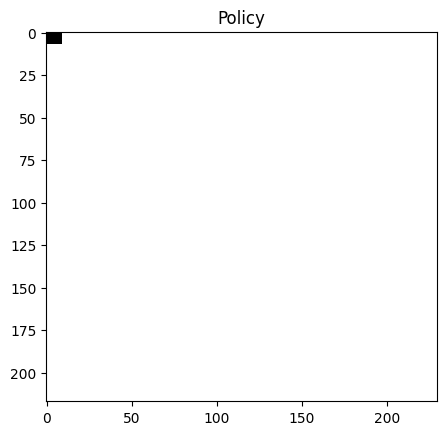

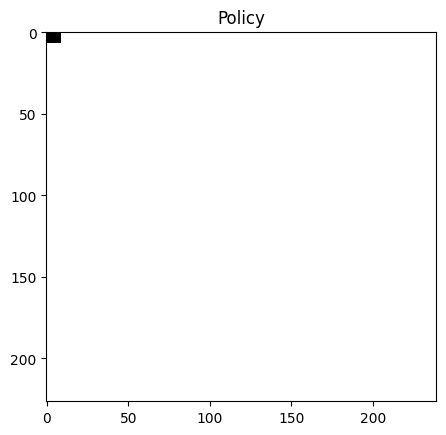

In [18]:
def plot_policy( policy_function ):

    #plt.figure()
    env.reset()
    img=env.render('rgb_array')

    plt.imshow( img.astype('float')/255.0)

    
    for row in range( policy_function.shape[0] ):
        for col in range( policy_function.shape[1] ):
            if policy_function[row,col] == 0:
                continue 
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = 0; dy = -.5
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            if policy_function[row,col] == 4:
                dx = .5; dy = 0
            plt.arrow( col*31 , row*41 , dx*12, dy*12 ,shape='full', fc='w' , ec='w' ,lw=3, head_width=3)
            #plt.quiver(col*31,row*40,dx,dy ,color=(1.0,1.0,1.0))
    plt.title( 'Policy' )        
    plt.show() 
plot_policy(policy_function1)
plot_policy(policy_function2)

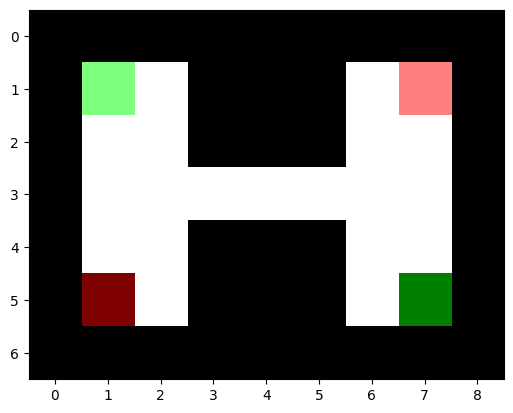

In [19]:
env.reset()
env.render()

# Q-learning with 10 step rollout

In [20]:
# Q learning params
ALPHA = 0.2 # learning rate
GAMMA = 0.95 # reward discount
LEARNING_COUNT = 2000
TEST_COUNT = 100

TURN_LIMIT = 1000
IS_MONITOR = True
import sys
#sys.path.append('/Users/maxja/IdeaProjects/multi-agent_distral')
from algorithms.Q_learning_rollout import Q_Learning_Rollout_Agents


env = GridworldEnv('1')
env.reset()
agents = Q_Learning_Rollout_Agents(env,LEARNING_COUNT,TURN_LIMIT,ALPHA,GAMMA,10)

print("###### LEARNING #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(LEARNING_COUNT):
    epsilon = agents.update_epsilon(i)
    total_reward,reward_1,reward_2=agents.learn(epsilon)
    reward_total_1 += reward_1
    reward_total_2 += reward_2
print("episodes      : {}".format(LEARNING_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / LEARNING_COUNT))
#print("agent 1 Q Value       :{}".format(agent.q_val))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / LEARNING_COUNT))

###### LEARNING #####
episodes      : 2000
agent 1 total reward  : 151587.6999999995
agent 1 average reward: 75.79
agent 2 total reward  : 129931.20000000014
agent 2 average reward: 64.97


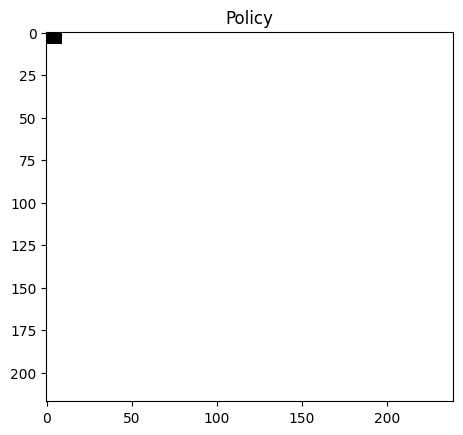

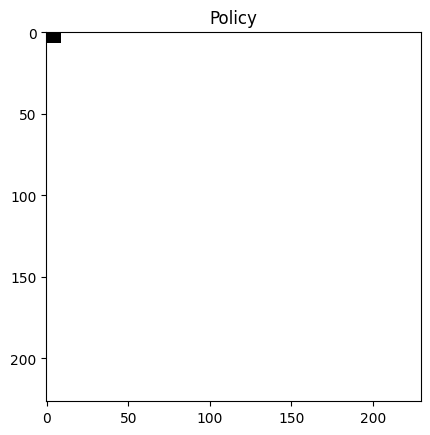

In [21]:
Q_a1 = agents.q_val_1
Q_a1_fixed_p2=Q_a1[:,:,1,7,:,:,:]
#Q_a1_fixed_p2=Q_a1
Q_a1_mean=np.mean(Q_a1_fixed_p2,axis=tuple(i for i in range(Q_a1_fixed_p2.ndim) if i != 0 and i!=1 and i!=4))

#print(Q_a1_mean[:,:,0])
policy_function1 = np.argmax(Q_a1_mean , axis = 2)

Q_a2 = agents.q_val_2 
Q_a2_fixed_p1=Q_a2[1,1,:,:,:,:,:]
#Q_a2_fixed_p1=Q_a2
#print(Q_a2_fixed_p1.shape)
Q_a2_mean=np.mean(Q_a2_fixed_p1,axis=tuple(i for i in range(Q_a2_fixed_p1.ndim) if i != 0 and i!=1 and i!=4))

policy_function2 = np.argmax( Q_a2_mean , axis = 2)

def plot_policy( policy_function ):

    #plt.figure()
    env.reset()
    img=env.render('rgb_array')

    plt.imshow( img.astype('float')/255.0)

    
    for row in range( policy_function.shape[0] ):
        for col in range( policy_function.shape[1] ):
            if policy_function[row,col] == 0:
                continue 
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = 0; dy = -.5
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            if policy_function[row,col] == 4:
                dx = .5; dy = 0
            plt.arrow( col*31 , row*41 , dx*12, dy*12 ,shape='full', fc='w' , ec='w' ,lw=3, head_width=3)
            #plt.quiver(col*31,row*40,dx,dy ,color=(1.0,1.0,1.0))
    plt.title( 'Policy' )        
    plt.show() 
plot_policy(policy_function1)
plot_policy(policy_function2)

# Soft Q-Learning Baseline

###### LEARNING #####
episodes      : 2000
agent 1 total reward  : -399999.9999999976
agent 1 average reward: -200.00
agent 2 total reward  : -399999.9999999976
agent 2 average reward: -200.00


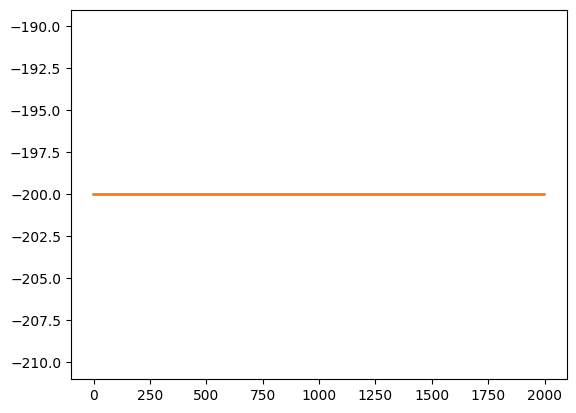

In [22]:
# Q learning params
ALPHA = 0.2 # learning rate
GAMMA = 0.95 # reward discount
TAU=0.5
LEARNING_COUNT = 2000
TEST_COUNT = 100

TURN_LIMIT = 1000
IS_MONITOR = True
from algorithms.Soft_Q_Learning_Baseline import Soft_Q_Learning_Baseline_Agents


env = GridworldEnv('1')
env.reset()
agents = Soft_Q_Learning_Baseline_Agents(env,LEARNING_COUNT,TURN_LIMIT,ALPHA,GAMMA,TAU)

print("###### LEARNING #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
rewards_1 = []
rewards_2 = []
for i in range(LEARNING_COUNT):
    total_reward,reward_1,reward_2=agents.learn()
    reward_total_1 += reward_1
    reward_total_2 += reward_2
    rewards_1.append(reward_1)
    rewards_2.append(reward_2)
print("episodes      : {}".format(LEARNING_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / LEARNING_COUNT))
#print("agent 1 Q Value       :{}".format(agent.q_val))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / LEARNING_COUNT))

plt.plot(range(len(rewards_1)), rewards_1)
plt.plot(range(len(rewards_2)), rewards_2)

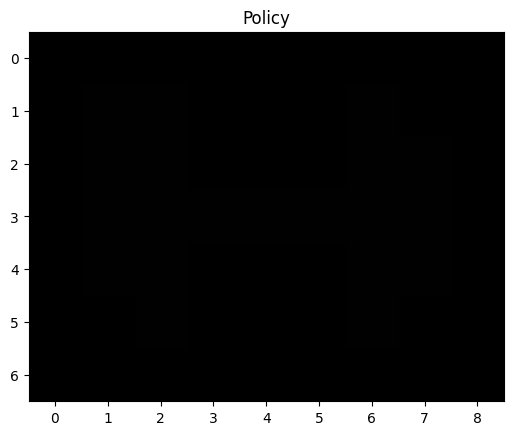

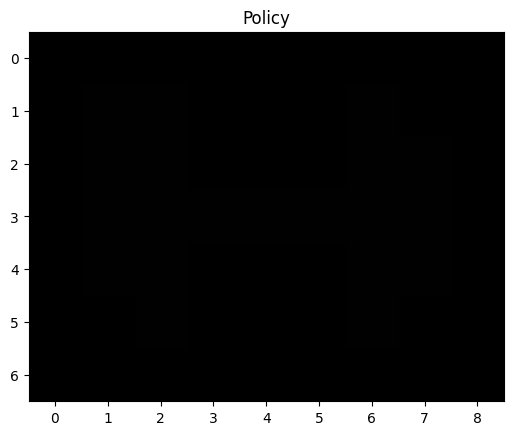

In [23]:
Q_a1 = agents.q_val_1
Q_a1_fixed_p2=Q_a1[:,:,1,7,:,:,:]
#Q_a1_fixed_p2=Q_a1
Q_a1_mean=np.mean(Q_a1_fixed_p2,axis=tuple(i for i in range(Q_a1_fixed_p2.ndim) if i != 0 and i!=1 and i!=4))

#print(Q_a1_mean[:,:,0])
policy_function1 = np.argmax(Q_a1_mean , axis = 2)

Q_a2 = agents.q_val_2 
Q_a2_fixed_p1=Q_a2[1,1,:,:,:,:,:]
#Q_a2_fixed_p1=Q_a2
#print(Q_a2_fixed_p1.shape)
Q_a2_mean=np.mean(Q_a2_fixed_p1,axis=tuple(i for i in range(Q_a2_fixed_p1.ndim) if i != 0 and i!=1 and i!=4))

policy_function2 = np.argmax( Q_a2_mean , axis = 2)

def plot_policy( policy_function ):

    #plt.figure()
    env.reset()
    img=env.render('rgb_array')

    plt.imshow( img.astype('float')/255.0)
    
    for row in range( policy_function.shape[0] ):
        for col in range( policy_function.shape[1] ):
            if policy_function[row,col] == 0:
                continue 
            if policy_function[row,col] == 1:
                dx = 0; dy = .5
            if policy_function[row,col] == 2:
                dx = 0; dy = -.5
            if policy_function[row,col] == 3:
                dx = -.5; dy = 0
            if policy_function[row,col] == 4:
                dx = .5; dy = 0
            plt.arrow( col*31 , row*41 , dx*12, dy*12 ,shape='full', fc='w' , ec='w' ,lw=3, head_width=3)
            #plt.quiver(col*31,row*40,dx,dy ,color=(1.0,1.0,1.0))
    plt.title( 'Policy' )        
    plt.show() 
plot_policy(policy_function1)
plot_policy(policy_function2)

In [7]:
import copy
import itertools
import os
import random
import sys

import numpy as np
import PIL.Image
from gym import spaces, Env
from gym.utils import seeding
import matplotlib.pyplot as plt

# Define the environment's elements
EMPTY, WALL, TARGET1, TARGET2, AGENT1, AGENT2, SUCCESS, TARGET1_OC2, TARGET2_OC1 = range(9)
ACTIONS = [NOOP, UP, DOWN, LEFT, RIGHT] = range(5)

# Define colors for rendering
COLORS = {
    EMPTY: [1.0, 1.0, 1.0],  # White
    WALL: [0.0, 0.0, 0.0],  # Black
    TARGET1: [0.0, 0.5, 0.0],  # Dark Green
    TARGET2: [0.5, 0.0, 0.0],  # Dark Red
    AGENT1: [0.5, 1.0, 0.5],  # Light Green
    AGENT2: [1.0, 0.5, 0.5],  # Light Red
    SUCCESS: [1.0, 0.0, 1.0],  # Pink
    TARGET1_OC2: [0.5, 0.5, 0.5],
    TARGET2_OC1: [0.5, 0.5, 0.5],
}

# Define the action to position update mapping
ACTION_EFFECTS = {
    NOOP: (0, 0),
    UP: (-1, 0),
    DOWN: (1, 0),
    LEFT: (0, -1),
    RIGHT: (0, 1),
}


class GridworldEnv(Env):
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, plan, from_file=True):
        super(GridworldEnv, self).__init__()
        self.action_space = {0: spaces.Discrete(5), 1: spaces.Discrete(5)}
        self.action_combinations = list(itertools.product(ACTIONS, repeat=2))

        # Load the grid map
        if from_file:
            this_file_path = os.path.dirname(os.path.realpath(__file__))
            grid_map_path = os.path.join(this_file_path, 'tasks/task{}.txt'.format(plan))
            self.start_grid_map = self._read_grid_map(grid_map_path)
        else:
            self.start_grid_map = np.array(plan, dtype=int)

        self.current_grid_map = np.copy(self.start_grid_map)
        self.observation_space = spaces.Box(low=0, high=max(EMPTY, WALL, TARGET1, TARGET2, AGENT1, AGENT2, SUCCESS),
                                            shape=self.current_grid_map.shape, dtype=int)

        # Initialize agents' states
        self.agents_start_coords, self.agents_target_coords = self._find_agents_and_targets()
        self.current_agents_coords = np.copy(self.agents_start_coords)
        self.move_completed = [False, False]
        self.episode_total_reward = 0.0
        self.viewer = None
        self.seed()

        # Env state: [agent 1 x position (this is actually vertical axis, sorry abt naming), agent 1 y position (this is actually horizontal axis), agent 2 x position, agent 2 y position, agent 1 previous action, flag on whether player 1 has reached goal – 1 if true, agent 2 previous action, flag on whether player 2 has reached goal – 1 if true]
        self.current_game_state = [self.current_agents_coords[0][0], self.current_agents_coords[0][1], self.current_agents_coords[1][0], self.current_agents_coords[1][1], NOOP, 0, NOOP, 0]

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_state_single(self, state, agent_idx):
        """
        Returns the state for the specified agent from the combined state.
        """
        # state of env has coordinates p1 +coordinates p2 + p1 prev action +  p1 reward so far + p2 prev action  + p2 reward so far
        # state of each agent should be coordinates p1 + coordinates p2 + their own prev action  + other agent's reward so far
        if agent_idx==0:
            return state[:5]+[state[7]]
        else:
            return state[:4]+[state[6]]+[state[5]]

    def get_legal_action_pairs(self):
        legal_action_pairs = []

        for comb in self.action_combinations:
            if self.move_legal(comb):
                legal_action_pairs.append(comb)

        return legal_action_pairs

    def move_legal(self, action_pair):

        # If an agent has reached their goal, they can only remain where they are
        if self.move_completed[0] == True and action_pair[0] != NOOP:
            return False

        if self.move_completed[1] == True and action_pair[1] != NOOP:
            return False

        dy_1, dx_1 = ACTION_EFFECTS[action_pair[0]]
        dy_2, dx_2 = ACTION_EFFECTS[action_pair[1]]
        y_1, x_1 = self.current_agents_coords[0][0] + dy_1, self.current_agents_coords[0][1] + dx_1
        y_2, x_2 = self.current_agents_coords[1][0] + dy_2, self.current_agents_coords[1][1] + dx_2

        # If the agents switch positions that's illegal
        if ((self.current_agents_coords[0][0] == y_2 and self.current_agents_coords[0][1] == x_2)
                or (self.current_agents_coords[1][0] == y_1 and self.current_agents_coords[1][1] == x_1)):
            return False

        return (self._within_bounds(y_1, x_1) and self._within_bounds(y_2, x_2)
                and self.current_grid_map[y_1, x_1] != WALL and self.current_grid_map[y_2, x_2] != WALL
                and (y_1, x_1) != (y_2, x_2))

    def step(self, actions):
        rewards = [0.0, 0.0]
        new_agent_coords = np.copy(self.current_agents_coords)

        if type(actions) is not tuple and len(actions) != 2:
            print(actions)

        for agent_idx, action in enumerate(actions):
            if self.move_completed[agent_idx]:
                continue

            dy, dx = ACTION_EFFECTS[action]
            y, x = self.current_agents_coords[agent_idx]
            new_y, new_x = y + dy, x + dx

            # Check for illegal moves
            if not self.move_legal(actions):
                rewards[agent_idx] = -0.1
                continue

            if self._target_reached(agent_idx, new_y, new_x):
                self.move_completed[agent_idx] = True
                rewards[agent_idx] = 100.0
            else:
                rewards[agent_idx] = -0.1

            new_agent_coords[agent_idx] = [new_y, new_x]

        self._update_grid_map(self.current_agents_coords, new_agent_coords)
        self.current_agents_coords = new_agent_coords

        self.current_game_state = [self.current_agents_coords[0][0], self.current_agents_coords[0][1], self.current_agents_coords[1][0], self.current_agents_coords[1][1], actions[0], int(self.move_completed[0]), actions[1], int(self.move_completed[1])]

        # Update game state and check if episode is done
        done = all(self.move_completed)
        return self.current_game_state, rewards, self.move_completed

    def reset(self):
        self.current_grid_map = np.copy(self.start_grid_map)
        self.current_agents_coords = np.copy(self.agents_start_coords)
        self.move_completed = [False, False]
        self.episode_total_reward = 0.0
        self.current_game_state = [self.current_agents_coords[0][0], self.current_agents_coords[0][1], self.current_agents_coords[1][0], self.current_agents_coords[1][1], NOOP, 0, NOOP, 0]
        return self.current_game_state

    def render(self, mode='human'):
        img = self._gridmap_to_image()
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            plt.imshow(img)
            plt.show()

    def _within_bounds(self, y, x):
        return 0 <= y < self.current_grid_map.shape[0] and 0 <= x < self.current_grid_map.shape[1]

    def _target_reached(self, agent_idx, y, x):
        target = TARGET1 if agent_idx == 0 else TARGET2
        return self.current_grid_map[y, x] == target

    def _find_agents_and_targets(self):
        start_coords = []
        target_coords = []
        for agent, target in [(AGENT1, TARGET1), (AGENT2, TARGET2)]:
            sy, sx = np.where(self.start_grid_map == agent)
            ty, tx = np.where(self.start_grid_map == target)
            start_coords.append([sy[0], sx[0]])
            target_coords.append([ty[0], tx[0]])
        return np.array(start_coords), np.array(target_coords)

    def _update_grid_map(self, old_coords, new_coords):

        old_grid_map = copy.deepcopy(self.current_grid_map)

        for (y, x) in old_coords:
            self.current_grid_map[y, x] = EMPTY

        for idx, (y, x) in enumerate(new_coords):
            self.current_grid_map[y, x] = AGENT1 if idx == 0 else AGENT2

        if new_coords[0][0] == self.agents_target_coords[0][0] and new_coords[0][1] == self.agents_target_coords[0][1]:
            self.current_grid_map[new_coords[0][0], new_coords[0][1]] = SUCCESS
        if new_coords[1][0] == self.agents_target_coords[1][0] and new_coords[1][1] == self.agents_target_coords[1][1]:
            self.current_grid_map[new_coords[1][0], new_coords[1][1]] = SUCCESS

        # In case an agent is on the other agent's target
        for i, (y, x) in enumerate(new_coords):
            if self.current_grid_map[y, x] == AGENT1 and (old_grid_map[y, x] == TARGET2 or old_grid_map[y, x] == TARGET2_OC1):
                self.current_grid_map[y, x] = TARGET2_OC1

            if self.current_grid_map[y, x] == AGENT2 and (old_grid_map[y, x] == TARGET1 or old_grid_map[y, x] == TARGET1_OC2):
                self.current_grid_map[y, x] = TARGET1_OC2

        # Check if agent moved away from occupying the foreign target
        if old_grid_map[old_coords[1][0], old_coords[1][1]] == TARGET1_OC2 and (new_coords[1][0] != old_coords[1][0] or new_coords[1][1] != old_coords[1][1]):
            self.current_grid_map[old_coords[1][0], old_coords[1][1]] = TARGET1

        if old_grid_map[old_coords[0][0], old_coords[0][1]] == TARGET2_OC1 and (new_coords[0][0] != old_coords[0][0] or new_coords[0][1] != old_coords[0][1]):
            self.current_grid_map[old_coords[0][0], old_coords[0][1]] = TARGET2

    def _gridmap_to_image(self):
        img = np.zeros((*self.current_grid_map.shape, 3))
        for i in range(self.current_grid_map.shape[0]):
            for j in range(self.current_grid_map.shape[1]):
                img[i, j] = COLORS[self.current_grid_map[i, j]]
        return img

    def _read_grid_map(self, grid_map_path):
        with open(grid_map_path, 'r') as file:
            grid_map = [[int(cell) for cell in line.split()] for line in file]
        return np.array(grid_map, dtype=int)





In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from gridworld_env import GridworldEnv

class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
        self.tanh = nn.Tanh()

    def forward(self, state):
        x = self.fc1(state)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.tanh(x)
        return x

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

class MADDPGAgent:
    def __init__(self, env, state_dim, action_dim, agent_id, lr_actor, lr_critic, gamma, tau):
        self.agent_id = agent_id
        self.env = env
        self.actor = ActorNetwork(state_dim, action_dim)
        self.critic = CriticNetwork(state_dim, action_dim)
        self.actor_target = ActorNetwork(state_dim, action_dim)
        self.critic_target = CriticNetwork(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = gamma
        self.tau = tau

        # Initialize target networks
        self.soft_update(self.actor, self.actor_target, 1.0)
        self.soft_update(self.critic, self.critic_target, 1.0)

    def act(self, state, epsilon=0.0):
        if np.random.rand() < epsilon:
            return self.env.action_space[self.agent_id].sample()
        else:
            state = torch.FloatTensor(state)
            action = self.actor(state)
            return action.detach().numpy()

    def update(self, batch, other_agents):
        state = torch.FloatTensor(batch['state'])
        action = torch.FloatTensor(batch['action'])
        reward = torch.FloatTensor(batch['reward'])
        next_state = torch.FloatTensor(batch['next_state'])
        done = torch.FloatTensor(batch['done'])

        # Update critic network
        next_actions = torch.cat([agent.actor_target(next_state[:, i*state_dim:(i+1)*state_dim]) for i, agent in enumerate(other_agents)], dim=1)
        target_q = self.critic_target(next_state, next_actions)
        expected_q = reward + self.gamma * (1 - done) * target_q
        critic_loss = nn.MSELoss()(self.critic(state, action), expected_q.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update actor network
        my_action = self.actor(state[:, self.agent_id*state_dim:(self.agent_id+1)*state_dim])
        actor_loss = -self.critic(state, torch.cat([agent.actor(state[:, i*state_dim:(i+1)*state_dim]) for i, agent in enumerate(other_agents)], dim=1))
        actor_loss = actor_loss.mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.actor_target, self.tau)
        self.soft_update(self.critic, self.critic_target, self.tau)

    def soft_update(self, source, target, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

class MADDPGTrainer:
    def __init__(self, env, state_dim, action_dim, lr_actor, lr_critic, gamma, tau, buffer_size, batch_size):
        self.env = env
        self.agents = [MADDPGAgent(env, state_dim, action_dim, i, lr_actor, lr_critic, gamma, tau) for i in range(2)]
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size

    def train(self, num_episodes, max_steps, epsilon_start, epsilon_end, epsilon_decay):
        for episode in range(num_episodes):
            state = self.env.reset()
            epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** episode))
            done = [False] * 2

            for step in range(max_steps):
                actions = [agent.act(state[i], epsilon) for i, agent in enumerate(self.agents)]
                next_state, rewards, done = self.env.step(actions)
                self.replay_buffer.add(state, actions, rewards, next_state, done)

                if all(done):
                    break

                batch = self.replay_buffer.sample(self.batch_size)
                for agent in self.agents:
                    agent.update(batch, [self.agents[i] for i in range(2) if i != agent.agent_id])

                state = next_state

            self.env.render(sum(rewards), done[0], f'episode_{episode}.png')

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = {'state': [], 'action': [], 'reward': [], 'next_state': [], 'done': []}

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer['state']) >= self.buffer_size:
            self.buffer['state'].pop(0)
            self.buffer['action'].pop(0)
            self.buffer['reward'].pop(0)
            self.buffer['next_state'].pop(0)
            self.buffer['done'].pop(0)

        self.buffer['state'].append(state)
        self.buffer['action'].append(action)
        self.buffer['reward'].append(reward)
        self.buffer['next_state'].append(next_state)
        self.buffer['done'].append(done)

    # def sample(self, batch_size):
    #     indices = np.random.choice(len(self.buffer['state']), size=batch_size, replace=False)
    #     batch = {key: [self.buffer[key][i] for i in indices] for key in self.buffer}
    #     return batch
    def sample(self, batch_size):
        if len(self.buffer['state']) < batch_size:
            indices = np.random.choice(len(self.buffer['state']), size=batch_size, replace=True)
        else:
            indices = np.random.choice(len(self.buffer['state']), size=batch_size, replace=False)
        batch = {key: [self.buffer[key][i] for i in indices] for key in self.buffer}
        return batch



[1, 7, 1, 1, 0, 0, 0, 0]

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from gridworld_env import GridworldEnv
lr_actor = 1e-4
lr_critic = 1e-3
gamma = 0.99
tau = 0.01
buffer_size = 10000
batch_size = 64
num_episodes = 1000
max_steps = 300
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
NUM_GAMES = 50
TURN_LIMIT = 200
IS_MONITOR = True
env = GridworldEnv('6')
env.reset()
state_dim = 8
action_dim = 5

num_agents = 2

trainer = MADDPGTrainer(env, state_dim, action_dim, lr_actor, lr_critic, gamma, tau, buffer_size, batch_size)
trainer.train(num_episodes, max_steps, epsilon_start, epsilon_end, epsilon_decay)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x10 and 13x64)